# **Deep Learning**
## ***Assignment 05***


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Dataset Loading***

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from torch import Tensor
import tensorflow as tf
import torch
import torch.nn as nn
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
import re 
from collections import Counter
import math
from torch.autograd import Variable
from sklearn.metrics import plot_confusion_matrix, f1_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import time


In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/IMDB_Dataset/imdb_dataset.csv')

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
X,y = reviews['review'].values,reviews['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (36000,)
shape of test data is (12000,)


In [ ]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## ***My Code For Encoding***

In [ ]:
from nltk.corpus import stopwords 
import re 
from collections import Counter

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
    corpus = Counter(word_list)

    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [ ]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
print(x_train.shape)
print(y_train.shape)

(36000,)
(36000,)


In [ ]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)
print(x_test_pad.shape)

(12000, 500)


## **Batching**

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
# dataloaders
batch_size = 500

train_data, val_data = train_test_split(train_data, test_size = 0.5)

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle= True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [ ]:
print(len(train_data))

18000


## **New RNN Cell**

In [ ]:
class CustomRNN(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz))
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):

        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t = init_states
         
        # HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]

####################          Activation Vector          ###############################

            h_t = torch.tanh( x_t @ self.W + h_t @ self.U + self.bias)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, h_t

## **New LSTM Cell**

In [ ]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):

        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
         
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]

####################          Activation Vector          ###############################

            gates = x_t @ self.W + h_t @ self.U + self.bias

#####################           Gates                  ################################
            input_t, forget_t, call_t, out_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
######################    Updating Cell State and Output Gate      ########################
            c_t = forget_t * c_t + input_t * call_t
            h_t = out_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

### **Custom GRU**

In [ ]:
class CustomGRU(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        ############# Weights for Update ##########################
        self.W_xz = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_hz = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz ))
        self.bias_z = nn.Parameter(torch.Tensor(hidden_sz))

        ############# Weights for Reset Gate  ######################
        self.W_xr = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_hr = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz ))
        self.bias_r = nn.Parameter(torch.Tensor(hidden_sz))

        ############# Weights for hidden gate #####################
        self.W_xh = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_hh = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz ))
        self.bias_h = nn.Parameter(torch.Tensor(hidden_sz))

        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):

        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t = init_states
         
        # HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]

####################          Update Gate          ###############################

            Z = torch.sigmoid( (x_t @ self.W_xz) + (h_t @ self.U_hz) + self.bias_z ) 

#####################         Reset Gate            ################################
            R = torch.sigmoid( (x_t @ self.W_xr) + (h_t @ self.U_hr) + self.bias_r)
 
######################        Hidden Gate           ##############################
            H_t = torch.tanh( (x_t @ self.W_xh) + ( ( R * h_t ) @ self.U_hh ) + self.bias_h )

            h_t = Z * h_t + (1 - Z) * H_t

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t)

## **Custom FC Layers**

In [ ]:
class Dense(nn.Module):
    def __init__(self, output_dim, layers):
        
        super().__init__()

        l = []
        for i in range(len(layers)):

            if i != len(layers) - 1:
                x = nn.Linear(layers[i], layers[i+1])
                a = nn.LeakyReLU()
                d = nn.Dropout(0.4)
                l.append(x)
                l.append(a)
                l.append(d)
            else:
                x = nn.Linear(layers[i], output_dim)
                a = nn.Sigmoid()
                l.append(x)
                l.append(a)

        self.dense = nn.Sequential(*l)
        # print(self.dense)

    def forward(self, x):

        x_ = self.dense(x)
        return x_


## **Initializing All Models**

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size, embeds_size, output_dim, layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeds_size)
        # self.lstm = CustomLSTM(embeds_size, layers[0])
        self.rnn = CustomRNN(embeds_size, layers[0])
        # self.gru = CustomGRU(embeds_size, layers[0])
        self.fc = Dense(output_dim, layers )
        
    def forward(self, x):
        x_ = self.embedding(x)
        # x_, (h_n, c_n) = self.lstm(x_)
        x_, h_n = self.rnn(x_) 
        # x_, h_n = self.gru(x_)
        x_ = (x_[:, -1, :])
        x_ = self.fc(x_)
        return x_

# **Setting Parameters**

In [ ]:
vocab_size = len(vocab) + 1
embeds_size = 32
output_dim = 1 
layers = [64, 32]
device = torch.device('cuda')
classifier = Net(vocab_size, embeds_size, output_dim, layers).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.05)#0.002 dives 85% acc
criterion = nn.BCELoss()
print(classifier)

## **Training And  Validation**

In [ ]:
%%time
def acc(pred, labels):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == labels.squeeze()).item()

def save_network(model):
  torch.save(model.state_dict(), "model.pth")

# optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# training params
clip = 5
num_epochs = 10
losses, val_losses = [], []
accuracy, val_accuracy = 0, 0
tr_acc, vl_acc = [], []
 

for epoch in range(num_epochs):

    train_acc = 0
    val_acc = 0

    for i, (seq, labels) in enumerate(train_loader):

        seq , labels = seq.to(device), labels.to(device)

        classifier.zero_grad()

        outputs = classifier(seq)

        loss = criterion(outputs.squeeze(), labels.float())
        
        loss.backward()

        accuracy = acc(outputs, labels.float())

        train_acc += accuracy

        nn.utils.clip_grad_norm_(classifier.parameters(), clip)

        optimizer.step()

        # if i % 50 == 0:
        #     print('Iteration: {} --> Train Loss: {:.3f}'.format(epoch+1, loss.item()) )
            
                

    train_acc = train_acc/len(train_loader.dataset)
    losses.append(loss.item()) 
    tr_acc.append(train_acc)

    for j, (input, labels) in enumerate(val_loader):

        input , labels = input.to(device), labels.to(device)

        outputs = classifier(input)

        val_loss = criterion(outputs.squeeze(), labels.float())

        val_accuracy = acc(outputs, labels.float())

        val_acc += accuracy 

        # if j % 50 == 0:
        #     print('Iteration: {} --> Validation Loss: {:.3f}'.format(epoch+1, val_loss.item()) )
            
    
    val_acc = val_acc / len(val_loader.dataset)
    val_losses.append(val_loss.item())
    vl_acc.append(val_acc)


    print('******* Results of Epoch : {} -->  Training Loss: {:.3f} --> Training Accuracy: {:.3f} *********'.format(epoch+1, loss.item(), train_acc*100 ) )
    print('******* Results of Epoch : {} -->  Validation Loss: {:.3f} --> Validation Accuracy: {:.3f} *********'.format(epoch+1, val_loss.item(), val_acc*100 ) )

  save_network(classifier)

## **Testing**

In [ ]:
%%time
test_loss, test_acc, test_accuracy = 0,0,0
target_list, pred_list = [], []

with torch.no_grad():
  for j, (input, labels) in enumerate(test_loader):

        input , labels = input.to(device), labels.to(device)

        outputs = classifier(input)

        pred = torch.round(outputs.squeeze())
        test_loss = criterion(outputs.squeeze(), labels.float())

        test_accuracy = acc(outputs, labels.float())

        test_acc += accuracy

        target_list.extend( list(labels.float().cpu()) )
        pred_list.extend( list(pred.cpu()) ) 
    
  test_acc = test_acc / len(test_loader.dataset)


print('******* Results of Testing -->  Test Loss: {:.3f} --> Test Accuracy: {:.3f} *********'.format(test_loss.item(), test_acc*100 ) )
   

******* Results of Testing -->  Test Loss: 0.400 --> Test Accuracy: 88.000 *********
CPU times: user 2.57 s, sys: 9.53 ms, total: 2.58 s
Wall time: 2.58 s


## **Confusion Matrix**

F1-Score :  0.8293652412109132


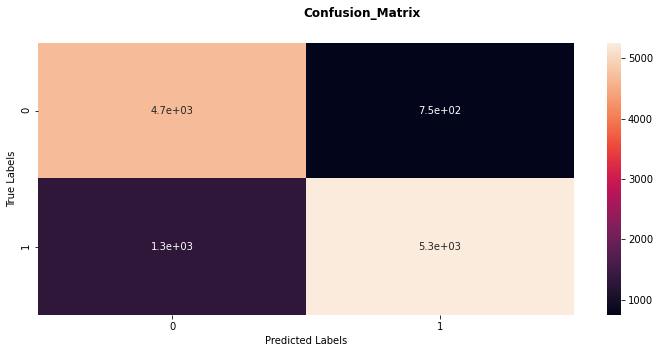

In [ ]:
  cm = confusion_matrix(pred_list,target_list)
  f1_scr = f1_score(pred_list, target_list, average='weighted')
  print("F1-Score : ",f1_scr)
  columns = [ str(i) for i in range(2) ]
  cm_df = pd.DataFrame(cm,columns,columns)  
  fig = plt.figure(figsize=(12,5)) 
  sns.heatmap(cm_df, annot=True)
  plt.ylabel("True Labels") 
  plt.xlabel("Predicted Labels")
  fig.suptitle("Confusion_Matrix", fontweight="bold")
  plt.savefig("confusion.png")
  plt.show()

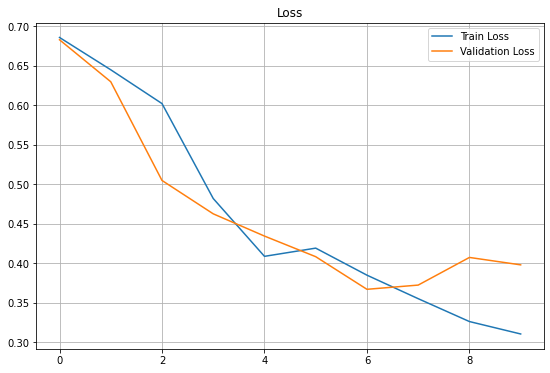

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss")
plt.legend()
plt.grid()

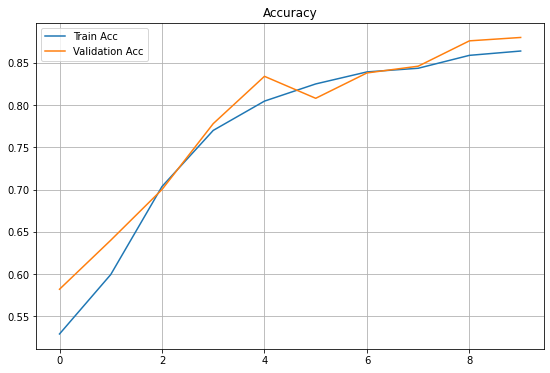

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(tr_acc, label='Train Acc')
plt.plot(vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        output = classifier(inputs)
        return(output.item())

## **Prediciting**

In [ ]:
import random
for k in range(10):
  index = random.randint(0, len(reviews))

  print(index)
  print('='*70)
  print("Review Sentence Index:" , index)
  print(f'Actual sentiment is  : {reviews["sentiment"][index]}')
  pro = predict_text(reviews['review'][index])
  status = "positive" if pro > 0.5 else "negative"
  pro = (1 - pro) if status == "negative" else pro
  print(f'Predicted sentiment is {status} with a probability of {pro}')
  print('='*70)

36254
Review Sentence Index: 36254
Actual sentiment is  : negative
Predicted sentiment is positive with a probability of 0.9627724885940552
8123
Review Sentence Index: 8123
Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.7362436652183533
24085
Review Sentence Index: 24085
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.8770615458488464
11421
Review Sentence Index: 11421
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.8816912174224854
27774
Review Sentence Index: 27774
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9832913279533386
40454
Review Sentence Index: 40454
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.7415866851806641
19077
Review Sentence Index: 19077
Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.8229416012763977
13425
Review Sentence 

Testing

In [ ]:
pro = predict_text(df['Review'][100])

In [ ]:
pro

0.8088632822036743

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IMDB_unlabeled_data/unlabeled.csv')

In [ ]:
df["Review"]

0       The best part about this movie is that you can...
1       This is the Australian TV series. It is a clas...
2       I saw this on TCM recently and, through the IM...
3       Golden Boy is ecchi humor (bordering on hentai...
4       If the screenwriter and director intended to o...
                              ...                        
1995    This is your typical junk comedy.<br /><br />T...
1996    Bad plot, bad dialogue, bad acting, idiotic di...
1997    I am a Catholic taught in parochial elementary...
1998    I'm going to have to disagree with the previou...
1999    No one expects the Star Trek movies to be high...
Name: Review, Length: 2000, dtype: object

In [ ]:
a = [20,30,40,50,60]

df["Age"] = a
df.to_csv("/content/Testing.csv", index=False)

In [ ]:
len(df)

2000

In [ ]:
pred_labels = []
for i in range(len(df)):
    index = i
    # print(df['Review'][index])
    # print('='*70)
    # print(f'Actual sentiment is  : {reviews["sentiment"][index]}')
    # print('='*70)
    pro = predict_text(df['Review'][index])
    status = "positive" if pro > 0.5 else "negative"
    pro = (1 - pro) if status == "negative" else pro
    a.append(status)
    # print(f'Predicted sentiment is {status} with a probability of {pro}')

In [ ]:
pred_labels = a[5:]

In [ ]:
print(pred_labels)

['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'po

In [ ]:
len(pred_labels)

2000

In [ ]:
df["Label"] = pred_labels
df.to_csv("/content/drive/MyDrive/IMDB_unlabeled_data/unlabeled.csv", index=False)
df

,ID,Review,Label
0,0,The best part about this movie is that you can...,positive
1,1,This is the Australian TV series. It is a clas...,positive
2,2,"I saw this on TCM recently and, through the IM...",positive
3,3,Golden Boy is ecchi humor (bordering on hentai...,positive
4,4,If the screenwriter and director intended to o...,positive
...,...,...,...
1995,1995,This is your typical junk comedy.<br /><br />T...,negative
1996,1996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
1997,1997,I am a Catholic taught in parochial elementary...,positive
1998,1998,I'm going to have to disagree with the previou...,positive


In [ ]:
z = df["Label"].value_counts()

In [ ]:
z[1]

995

In [ ]:
print("Predicted Positive Labels", z[0]/2000 * 100)
print("Predicted Negative Labels", z[1]/2000 *100)

Predicted Positive Labels 50.24999999999999
Predicted Negative Labels 49.75


In [ ]:
s = "This was a bad movie" 
pro = predict_text(s)
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
# a.append(status

In [ ]:
status

'negative'

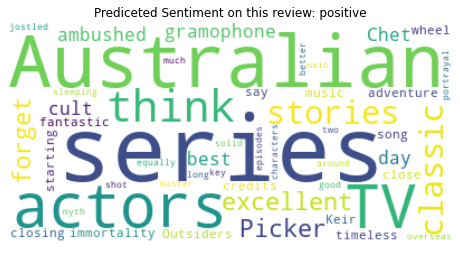

In [ ]:
# |# Word Cloud that shows main words used in reviews that are positive or negative  
# Randomly select one sentence that has positive sentiment and one with negative sentiment 
q = df["Review"][1]
# make word cloud of those sentences and see what are main words used in positive review and in negative reviews
# Similarly you can make word clouds of all positive reviews and negative reviews to see the most repeating words in positive sentiments and negative sentiments
plt.figure(figsize=(8,8))
plt.title('Prediceted Sentiment on this review: '+ 'positive')
wordcloud = WordCloud(background_color='White',max_words=100).generate(q)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
def preprocess(text):
    lower = text.lower()
    # Removing Punctuation marks
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    rem_punc = tokenizer.tokenize(lower)
    # Removing Stop Words
    stopwords = nltk.corpus.stopwords.words('english')
    rem_stop_words = [word for word in rem_punc if not word in stopwords]
    # Removing Non-English words 
    english_words = nltk.corpus.words.words()
    english_words = [word for word in rem_stop_words if word in english_words]   
    # Insert Start End tokens
    english_words.insert(0,'<start>')
    english_words.append('<end>')
    sentence = ' '.join(english_words)
    return sentence

In [ ]:
def encode_text(text):
    # Tokenization
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(text)
    # Converting to sequences
    sequences = tokenizer.texts_to_sequences(text)
    # Padding Zeros 
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')
    
    return padded_sequences, tokenizer

In [ ]:
text = list(map(preprocess,df["Review"][:100]))
encodings, tokenizer = encode_text(text)

In [ ]:
counts = tokenizer.word_counts

In [ ]:
all_words = list(counts.keys())

In [ ]:
all_words[0]

'start'

In [ ]:
len(all_words)

2485

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        output = classifier(inputs)
        return(output.item())

In [ ]:
def pred_sentiment(all_words):
    positive_words = []
    negative_words = []

    for i in range(len(all_words)):
        # print(all_words[i])
        # print('='*70)
        # print(f'Actual sentiment is  : {reviews["sentiment"][index]}')
        # print('='*70)
        pro = predict_text(all_words[i])
        status = "positive" if pro > 0.5 else "negative"
        pro = (1 - pro) if status == "negative" else pro
        positive_words.append(all_words[i]) if status== "positive" else negative_words.append(all_words[i])

        # print(f'Predicted sentiment is {status} with a probability of {pro}')
    return positive_words, negative_words

In [ ]:
def plot_word_cloud(data, sentiment_type):
    plt.figure(figsize=(12,12))
    plt.title('Prediceted Sentiment on this review: '+ sentiment_type)
    wordcloud = WordCloud(background_color='White',max_words=100).generate(str(data))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

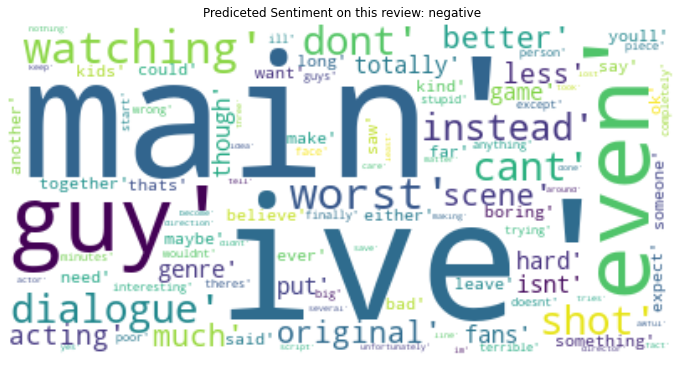

In [ ]:
# |# Word Cloud that shows main words used in reviews that are positive or negative  
# Randomly select one sentence that has positive sentiment and one with negative sentiment 
# make word cloud of those sentences and see what are main words used in positive review and in negative reviews
# Similarly you can make word clouds of all positive reviews and negative reviews to see the most repeating words in positive sentiments and negative sentiments
plt.figure(figsize=(12,12))
plt.title('Prediceted Sentiment on this review: '+ 'negative')
wordcloud = WordCloud(background_color='White',max_words=100).generate(str(negative_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
x_test[1]

"Van Sant copies Hitchcock's masterpiece shot for shot including some modern facets: a walkman, and nudity from Anne Heche. Unless you have a strong desire to see Ms. Heche naked there is absolutely NO reason to see this film instead of the original. Hitchcock's masterpiece is much better and Van Sant fails to realize that in hiding the nudity and the gore, the original shower scene is all the more terrifying. Ask Janet Leigh about that one. The acting is also much flatter and the technical aspects much less impressive."

In [ ]:
def tockenize(x_test):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_test:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
    corpus = Counter(word_list)
    return corpus

In [ ]:
X,y = reviews['review'].values,reviews['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (36000,)
shape of test data is (12000,)


In [ ]:
tockens = tockenize(x_train)

In [ ]:
tockens

In [ ]:
tocken_words = []
for key,value in tockens.items():
    if(value >= 500):
        tocken_words.append(key)
len(tocken_words)

1346

In [ ]:
positive_words, negative_words = pred_sentiment(tocken_words)

In [ ]:
len(positive_words)

950

In [ ]:
len(negative_words)

396

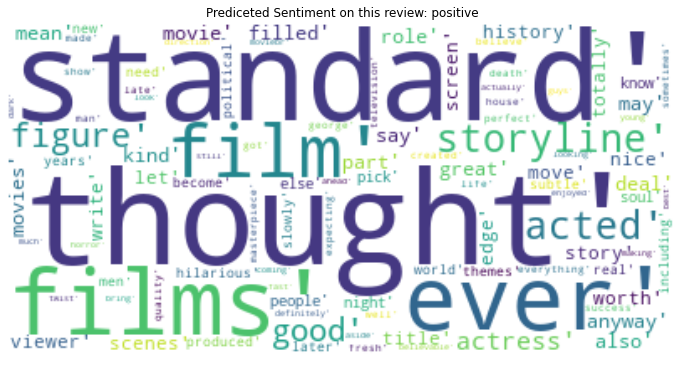

In [ ]:
plot_word_cloud(positive_words, "positive")

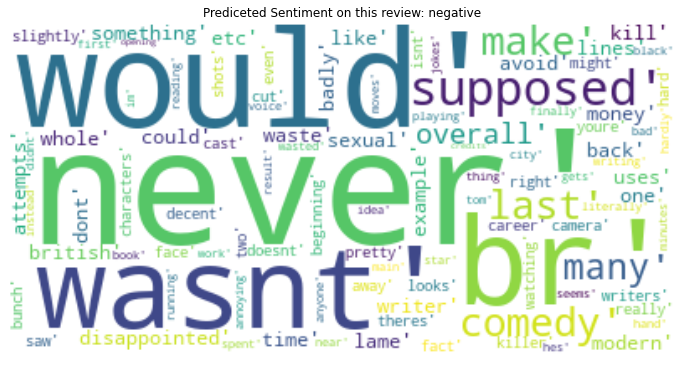

In [ ]:
plot_word_cloud(negative_words, "negative")